# My year of plastic in 10 charts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy import stats #for streamgraph
import seaborn as sns
import matplotlib.patches as patches
import pickle
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from datetime import date, datetime

%matplotlib inline

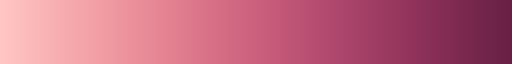

In [2]:
from palettable.cartocolors.sequential import Magenta_7, PurpOr_7, BluYl_7, DarkMint_7, BurgYl_7, Burg_7, BrwnYl_7
from palettable.colorbrewer.sequential import YlGnBu_9, Blues_9
Burg_7.mpl_colormap

In [21]:
# set root folder
root = os.path.abspath(os.path.join(os.getcwd(), ".."))

#get data - open pickled file
file = open(os.path.join(root, "data\\lisa_plastic_records_history_clean"),'rb')
df = pickle.load(file)
file.close()

#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
#set fonts for plots
font_r = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\MYRIADPRO-REGULAR.OTF')
font_m = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\MYRIADPRO-SEMIBOLD.OTF')
font_b = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\MYRIADPRO-BOLD.OTF')

# Preparation

## aggregated data per day

In [4]:
#aggregate data by day + category
data_daily = df.groupby(["date", "category_name", "sub_category_name"]).agg({"plastic_weight":"sum",
                                                                            "score":"sum", 
                                                                            "quantity": "sum",
                                                                            "DV_plastic_weight":"sum"})
data_daily = data_daily.reset_index()

#get all days for 2021 and join with data
all_days = pd.DataFrame(pd.date_range('1/1/2021', periods=365, freq='D')).rename(columns={0:"date"})
df_daily = pd.merge(all_days, data_daily, left_on="date", right_on = "date", how='outer')

In [5]:
#get calendarweeks and month

df["ISOyear"] = df["date"].dt.isocalendar()["year"]
df["ISOweek"] = df["date"].dt.isocalendar()["week"]

#get weeks commencing
weeks = df[["ISOyear", "ISOweek"]].drop_duplicates().reset_index(drop=True)

week_commencing = []

for i in range(len(weeks)):
    x = pd.to_datetime(date.fromisocalendar(weeks["ISOyear"][i],weeks["ISOweek"][i],1))
    week_commencing.append(x)
    
weeks["week_commencing"] = week_commencing

#merge back to dataframe
df = pd.merge(df, weeks, left_on=["ISOyear", "ISOweek"], right_on=["ISOyear", "ISOweek"], how='left')

#get month based on weeks commencing
df["month"] = df["week_commencing"].dt.month
df.loc[df["week_commencing"] =="2020-12-28", "month"] = 1

# 0. Overview poster

## Total weight

In [6]:
df["DV_plastic_weight"].sum()/2

15967.0

## Total weight per category

In [7]:
pivot = df.groupby("category_name")["DV_plastic_weight"].sum().to_frame()
pivot = pivot.sort_values(by="DV_plastic_weight", ascending=False)
pivot["Percent"] = pivot["DV_plastic_weight"]/ (pivot["DV_plastic_weight"].sum()) *100
pivot

,DV_plastic_weight,Percent
category_name,,
"Pots, tubs, trays",10821,33.885514
Bottles,10707,33.528528
Bags and film,6096,19.089372
Cupboard and Hygiene,3280,10.271184
Other,968,3.031252
Drinks,62,0.19415


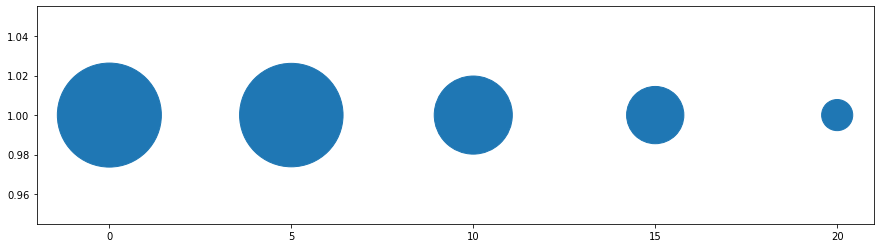

In [35]:
data = pivot.iloc[:5]["DV_plastic_weight"].to_list()

fig, ax = plt.subplots(figsize=(15, 4))
plt.scatter([0,5,10,15,20], [1,1,1,1,1], s=data)
plt.gca().set_xlim(xmin=-2)

#export to svg
plt.savefig(os.path.join(root, "outputs//bubbles.svg"))

plt.show()

## Largest category per month

In [57]:
pivot = df.groupby(["month","category_name"])["DV_plastic_weight"].sum().to_frame()
pivot.unstack()

DV_plastic_weight                                            \
category_name     Bags and film Bottles Cupboard and Hygiene Drinks Other   
month                                                                       
1                           769    1006                  273      2   118   
2                           541     796                  212     10   349   
3                           640     943                  380     12    53   
4                           565     658                  439      4    61   
5                           510     995                  245      5    30   
6                           394    1036                  358      1    59   
7                           466    1155                  199      8   130   
8                           626    1205                  435     10    33   
9                           402     696                  272      4    84   
10                          315     706                   29    NaN     7   
11                          511     801                   70      2    11   
12                          357     710                  368      4    33   

                                 
category_name Pots, tubs, trays  
month                            
1                          1133  
2                          1152  
3                          1162  
4                          1010  
5                          1036  
6                           879  
7                           865  
8                          1066  
9                           763  
10                          533  
11                          565  
12                          657

## Radar plot

In [27]:
# get bin number by day for heatmap calendar view 
pivot = df.groupby("date")["DV_plastic_weight"].sum()
counts, bin_edges = np.histogram(pivot, bins=5)
print(bin_edges)

pivot = df.groupby("date")["DV_plastic_weight"].sum()
pivot = pivot.to_frame()
day_bins = []

for weight in pivot["DV_plastic_weight"]:
    if weight <=81.8:
        day_bins.append(1)
    elif (weight > 81.8) & (weight <= 154.6):
        day_bins.append(2)   
    elif (weight > 154.6) & (weight <= 227.4):
        day_bins.append(3)  
    elif (weight > 227.3) & (weight <= 300.2):
        day_bins.append(4)      
    elif weight > 300.2:
        day_bins.append(5)  
        
pivot["day_bins"] = day_bins

pivot.to_csv("day_bins.csv")

array([9.0, 81.8, 154.6, 227.39999999999998, 300.2, 373.0], dtype=object)

In [40]:
pivot = df.groupby(["date", 
                    "week_commencing"])["DV_plastic_weight"].sum().to_frame().reset_index()

#append empty weight for missing week
new_values = [pd.to_datetime("2021-10-04"), pd.to_datetime("2021-10-04"), 0]
length = len(pivot)
pivot.loc[length] = new_values

pivot = pivot.sort_values(by="week_commencing")
pivot.head()

,date,week_commencing,DV_plastic_weight
0,2021-01-01,2020-12-28,91
1,2021-01-02,2020-12-28,135
2,2021-01-03,2020-12-28,55
8,2021-01-09,2021-01-04,156
7,2021-01-08,2021-01-04,54


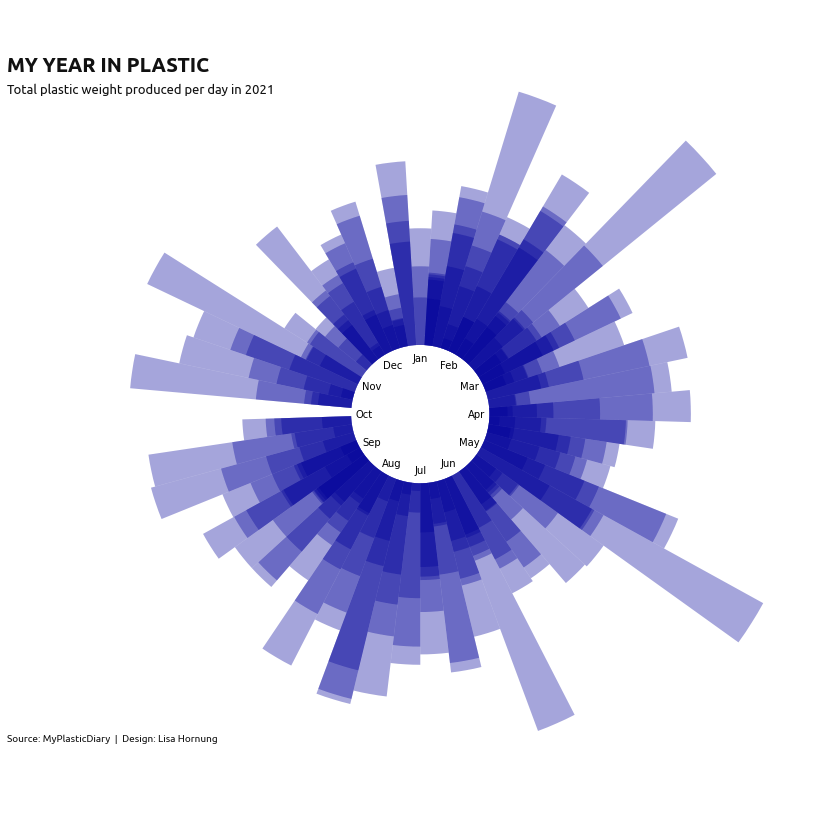

In [43]:
data = pivot

# =========
# Initialise Figure and define layout
plt.figure(figsize=(15, 15))
ax = plt.subplot(111, polar=True)

# ============
#data
n_points = len(data["week_commencing"].unique())
inner_radius = 80
bar1 = data["DV_plastic_weight"]

x_max = 2*np.pi
x_coords = np.linspace(0, x_max, n_points, endpoint=False)
width = x_max / n_points

#map x_coords to week commencing
dictionary = dict(zip(data["week_commencing"].unique(), x_coords))
x_pos = data["week_commencing"].map(dictionary)

#add bars
ax.bar(
    x_pos,
    bar1,
    width=width,
    bottom=inner_radius,
    color="#000099",
    alpha=0.35
)

#============
# labels for months
l_points = 12
label_x_pos = np.linspace(0, x_max, l_points, endpoint=False)
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#add value labels and categories
for i in range(l_points):
    ax.text(label_x_pos[i], 65, 
            labels[i],
            size=10,
            ha="center", va='center')

#configure theta location and direction
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.axis('off')

# =========
#title and footer
title = "MY YEAR IN PLASTIC"
subtitle = "Total plastic weight produced per day in 2021"
x_title=0.13
plt.figtext(x_title,0.82, title, size=20, ha='left',  fontproperties = font_b, color='#111111')
plt.figtext(x_title,0.8, subtitle, size=13,ha='left',  fontproperties = font_r, color='#111111')

plt.figtext(x_title,0.2, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color='#111111')


#save
plt.savefig(os.path.join(root, "outputs//radar-plot.png"), bbox_inches="tight",pad_inches=0.2, transparent=False)
plt.savefig(os.path.join(root, "outputs//radar-plot.svg"))

plt.show()

# Chart 1 - calendar heatmap

In [23]:
#colors
colpalette = BurgYl_7
col_main = colpalette.mpl_colors

#Fontstyles
def get_text():
    title = ("Tracking my daily plastic consumption in 2021").upper()
    subtitle = "Total single use plastic weight per day (g)"
    
    return(title, subtitle)

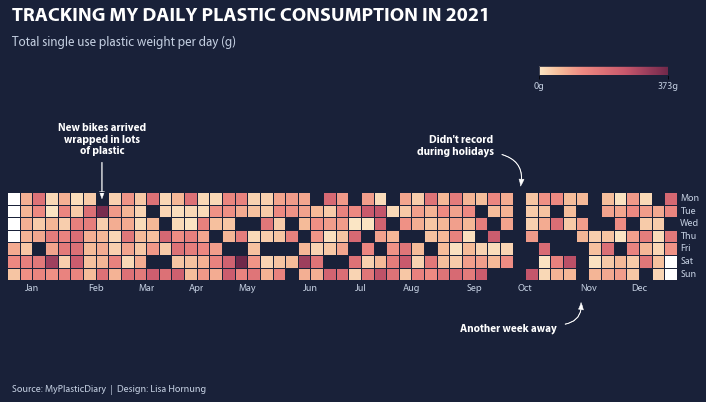

In [24]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
cols = {"back": "#192139", "edges":"#c3cee0", "text": "#c3cee0", "title": "white"}

#colors
colpalette = BurgYl_7
col_main = colpalette.mpl_colors

title = ("Tracking my daily plastic consumption in 2021").upper()
subtitle = "Total single use plastic weight per day (g)"


#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(cols["back"])
ax = calplot.yearplot(events, cmap=colpalette.mpl_colormap, linewidth=1, linecolor=cols["back"], fillcolor=cols["back"],
                      edgecolor = cols["back"],  dropzero=True, zorder=2)
ax.set_xticklabels(ax.get_xticklabels(), color=cols["text"], fontproperties=font_r)
ax.set_yticklabels(ax.get_yticklabels(), color=cols["text"], fontproperties=font_r)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color=cols["title"])

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False, zorder=4)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False, zorder=4)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False, zorder=4)

#add arrows to plot
for a in [a1, a2,a3]:
    ax.add_patch(a)

## =========
#annotations
ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_b,
        color=cols["title"])  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=11, ha='right', fontproperties = font_b, color=cols["title"])
ax.text(43.5, -4, "Another week away", fontsize=11, ha='right', fontproperties = font_b, color=cols["title"])

## =========
#add colorbar (create mappable first and then plot)
cbaxes = fig.add_axes([0.74, 0.95, 0.15, 0.025]) #axes to hold coloebar
cmappable = ScalarMappable(norm=Normalize(0,int(events.max())), cmap=colpalette.mpl_colormap)
cb = plt.colorbar(cmappable, cax = cbaxes, anchor=(1,1.2), orientation='horizontal',
            ticks=[0,  int(events.max())])
cb.set_ticklabels(["0g", str(int(events.max()))+"g" ], fontproperties=font_r, color=cols["text"])
cb.outline.set_color(cols["back"])  

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.1, title, size=20, ha='left',  fontproperties = font_b, color=cols["title"])
plt.figtext(x_title,1.03, subtitle, size=13,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.07, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.2)

plt.show()

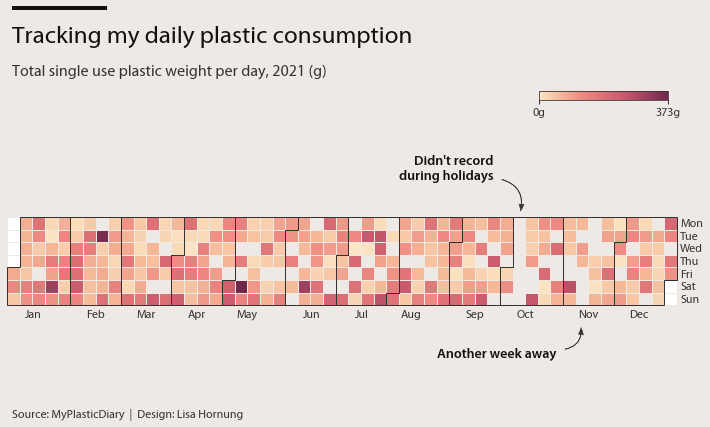

In [80]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
cols = {"back": "#efe9e5", "edges":"white", "text": "#333333", "title": "#111111"}

#colors
colpalette = BurgYl_7
col_main = colpalette.mpl_colors

title = ("Tracking my daily plastic consumption")
#.upper()
subtitle = "Total single use plastic weight per day, 2021 (g)"

#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(cols["back"])
ax = calplot.yearplot(events, cmap=colpalette.mpl_colormap, linewidth=1, linecolor=cols["back"], fillcolor=cols["back"],
                      edgecolor = cols["text"],  dropzero=True)
ax.set_xticklabels(ax.get_xticklabels(), color=cols["text"], fontproperties=font_r, size=12)
ax.set_yticklabels(ax.get_yticklabels(), color=cols["text"], fontproperties=font_r, size=12)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color=cols["text"])

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a2,a3]:
    ax.add_patch(a)

## =========
#annotations
#ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_m,
        #color=cols["title"])  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=14, ha='right', fontproperties = font_m, color=cols["title"])
ax.text(43.5, -4, "Another week away", fontsize=14, ha='right', fontproperties = font_m, color=cols["title"])

## =========
#add colorbar (create mappable first and then plot)
cbaxes = fig.add_axes([0.74, 0.95, 0.15, 0.025]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,int(events.max())), cmap=colpalette.mpl_colormap)
cb = plt.colorbar(cmappable, cax = cbaxes, anchor=(1,1.2), orientation='horizontal',
            ticks=[0,  int(events.max())])
cb.set_ticklabels(["0g", str(int(events.max()))+"g" ], fontproperties=font_r, color=cols["text"],size=12)
cb.outline.set_color(cols["text"])    


## =========
#add accent line
laxes = fig.add_axes([0.13, 1.2, 0.11, 0.01]) #axes to hold colorbar
laxes.set_ylim(ymin=0, ymax=1)
laxes.set_facecolor("#111111")
for pos in ["top", "bottom", "left", "right"]:
    laxes.spines[pos].set_visible(False)
laxes.set_yticks([])
laxes.set_xticks([])

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.11, title, size=25, ha='left',  fontproperties = font_r, color=cols["title"])
plt.figtext(x_title,1.02, subtitle, size=16,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.07, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=12, ha='left', fontproperties = font_r, color=cols["text"])

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.4)

plt.show()

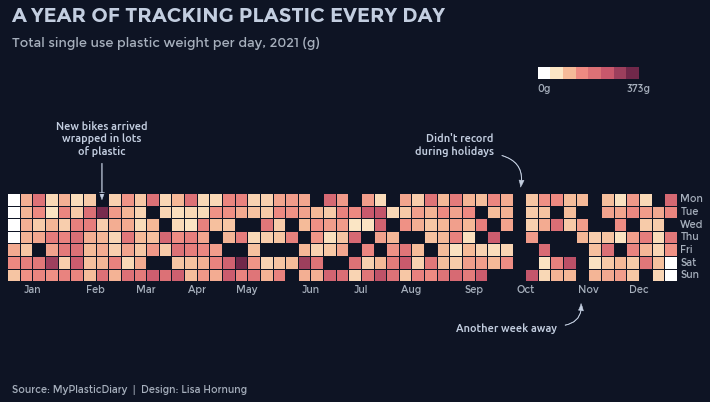

In [61]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
cols = {"back": "#0e1424", "edges":"#c3cee0", "text": "#a6afbc", "title": "#c3cee0"}
font_r, font_b, title, subtitle = get_text()

#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(cols["back"])
ax = calplot.yearplot(events, cmap=colpalette.mpl_colormap, linewidth=1, linecolor=cols["back"], fillcolor=cols["back"],
                      edgecolor = cols["back"],  dropzero=True)
ax.set_xticklabels(ax.get_xticklabels(), color=cols["text"], fontproperties=font_r)
ax.set_yticklabels(ax.get_yticklabels(), color=cols["text"], fontproperties=font_r)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color=cols["title"])

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a1, a2,a3]:
    ax.add_patch(a)

## =========
#annotations
ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_m,
        color=cols["title"])  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=11, ha='right', fontproperties = font_m, color=cols["title"])
ax.text(43.5, -4, "Another week away", fontsize=11, ha='right', fontproperties = font_m, color=cols["title"])

## =========
#add colorbar (custom ...)
x_pos = 42
y_pos = 16

ax.text(x_pos,y_pos-1, "0g", fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])  
ax.add_patch(patches.Rectangle((x_pos, y_pos), 1, 1, edgecolor=None, facecolor='white', linewidth=0.7, clip_on=False))
for c in colpalette.mpl_colors:
    ax.add_patch(patches.Rectangle((x_pos+1, y_pos), 1, 1, edgecolor=None, facecolor=c, linewidth=0.7, clip_on=False))
    x_pos +=1
ax.text(x_pos,y_pos-1, str(int(events.max()))+"g", fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])  

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.1, title, size=20, ha='left',  fontproperties = font_b, color=cols["title"])
plt.figtext(x_title,1.03, subtitle, size=13,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.07, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.2)

plt.show()

# Chart 2: Total consumption - bubbles

In [18]:
print("total items:", df["quantity"].sum())
print("total weight:", df["DV_plastic_weight"].sum())
print("max weight for single item:", df["DV_plastic_weight"].max())

total items: 2556
total weight: 31934
max weight for single item: 122


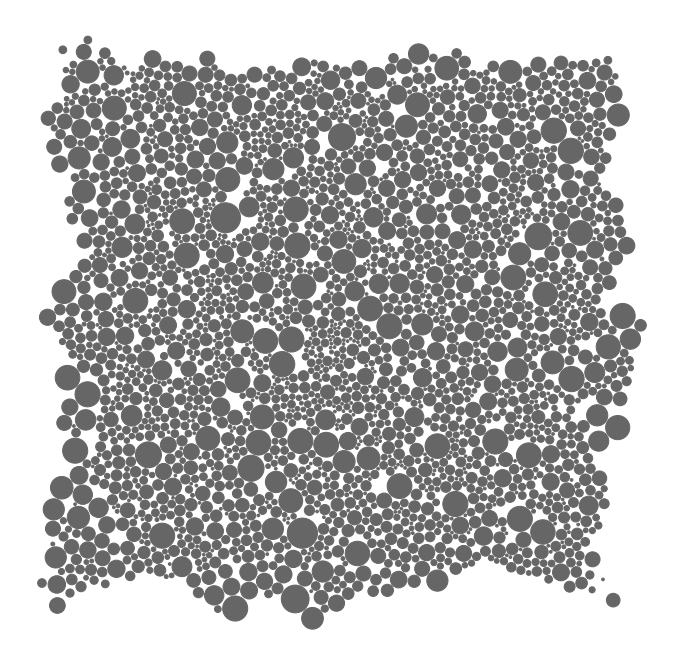

In [11]:
data = df[["category_name", "DV_plastic_weight"]]
#.sort_values(by="DV_plastic_weight", ascending=False)

colors = "#666666"

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=200):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors)
            ax.add_patch(circ)

bubble_chart = BubbleChart(area=data['DV_plastic_weight'].to_list(),
                           bubble_spacing=0.5)

bubble_chart.collapse()

fig, ax = plt.subplots(figsize=(12,12))
bubble_chart.plot(
    ax, data['category_name'], colors)
ax.axis("off")
ax.relim()
ax.autoscale_view()

plt.savefig(os.path.join(root, "outputs//bubbles_sea.svg"))
plt.savefig(os.path.join(root, "outputs//bubbles_sea.png"))


plt.show()

In [9]:
plt.savefig(os.path.join(root, "outputs//bubbles_sea.svg"))

<Figure size 432x288 with 0 Axes>

# Chart 3: Treemap - largest category

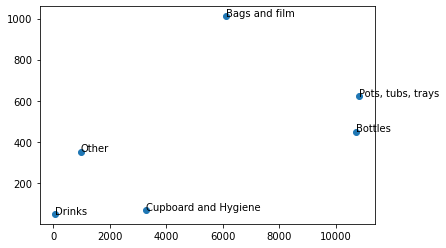

In [408]:
data = df.groupby(["category_name"]).agg({"DV_plastic_weight":"sum", "quantity":"sum"}).reset_index()

plt.scatter(data["DV_plastic_weight"], data["quantity"])

for i in range(len(data)):
    plt.text(data["DV_plastic_weight"][i],data["quantity"][i], data["category_name"][i])

In [220]:
pivot = df.groupby(["category_name"]).agg({"DV_plastic_weight":"sum", "quantity": "sum"})
pivot

,DV_plastic_weight,quantity
category_name,,
Bags and film,6096,1011
Bottles,10707,450
Cupboard and Hygiene,3280,69
Drinks,62,50
Other,968,353
"Pots, tubs, trays",10821,623


In [236]:
df[["category_name", "sub_category_name"]].value_counts().to_frame().reset_index().sort_values(by="category_name")


,category_name,sub_category_name,0
0,Bags and film,Produce bags,841
9,Bags and film,Carrier bags,60
11,Bags and film,Cling film,56
12,Bags and film,Soft plastic pouches,53
25,Bags and film,Food bags and wrappings,1
2,Bottles,Tetrapak and similar,251
5,Bottles,Drink & Oil,151
18,Bottles,Milk,6
17,Bottles,Bottle cap,20
15,Bottles,Ketchup and similar,22


# Chart 4: Reduction over time - stacked bar

In [230]:
pivot = df.groupby(["week_commencing", "category_name"])["DV_plastic_weight"].sum().to_frame().unstack()
pivot.columns = pivot.columns.droplevel(level=0)
pivot = pivot.reset_index()

#exclude weeks where we didn't record consistently
pivot = pivot[(pivot["week_commencing"]!="2021-11-08") & 
              (pivot["week_commencing"]!="2021-11-15")].set_index("week_commencing")
pivot["Total"] = pivot.sum(axis=1)
pivot = pivot.fillna(0)
pivot.head()

category_name,Bags and film,Bottles,Cupboard and Hygiene,Drinks,Other,"Pots, tubs, trays",Total
week_commencing,,,,,,,
2020-12-28,28,126,0,2,0,125,281.0
2021-01-04,206,192,25,0,24,207,654.0
2021-01-11,152,175,148,0,25,280,780.0
2021-01-18,211,304,0,0,48,251,814.0
2021-01-25,172,209,100,0,21,270,772.0


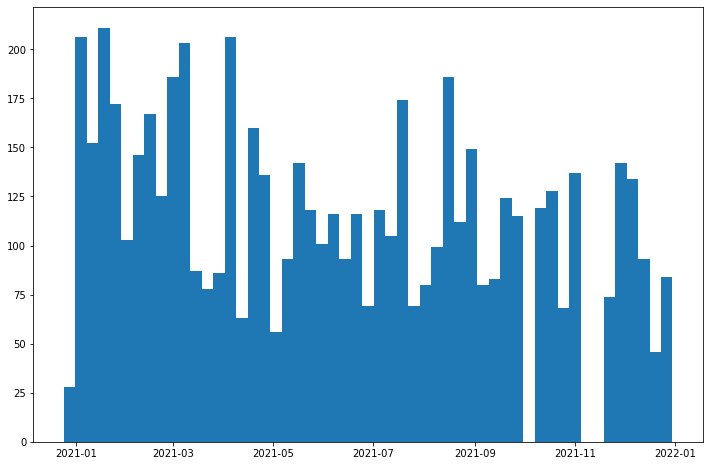

In [232]:
#chart
data = pivot

fig, ax = plt.subplots(figsize=(12,8))

#ax.bar(data.index, data["Total"], width=7)

for column in ['Bags and film', 'Bottles', 'Cupboard and Hygiene', 'Drinks', 'Other','Pots, tubs, trays']:
    ax.bar(data.index, data[column], width=7)
    plt.show()


#ax.bar(data["week_commencing"], data["quantity"], width=7)

#ax.scatter(data["DV_plastic_weight"], data["quantity"])
#ax.plot(data["week_commencing"], data["DV_plastic_weight"])
#ax.fill_between(data["week_commencing"], data["DV_plastic_weight"])
#pivot["DV_plastic_weight"].plot()

#ax.set_ylim(ymin=0)

for pos in ["top", "right", "left"]:
    ax.spines[pos].set_visible(False)

#plt.show()

In [189]:
pivot = df.groupby(["week_commencing", "category_name"])["quantity"].sum().to_frame().unstack()
pivot.columns = pivot.columns.droplevel(level=0)
pivot = pivot.reset_index()

#exclude weeks where we didn't record consistently
pivot = pivot[(pivot["week_commencing"]!="2021-11-08") & 
              (pivot["week_commencing"]!="2021-11-15")].set_index("week_commencing")
pivot["Total"] = pivot.sum(axis=1)
pivot.head()

category_name,Bags and film,Bottles,Cupboard and Hygiene,Drinks,Other,"Pots, tubs, trays",Total
week_commencing,,,,,,,
2020-12-28,7.0,7.0,NaN,2.0,NaN,10.0,26.0
2021-01-04,31.0,12.0,3.0,NaN,8.0,11.0,65.0
2021-01-11,22.0,13.0,4.0,NaN,11.0,18.0,68.0
2021-01-18,25.0,11.0,NaN,NaN,4.0,11.0,51.0
2021-01-25,20.0,12.0,2.0,NaN,5.0,17.0,56.0


In [198]:
pivot = df[df["category_name"]=="Pots, tubs, trays"].groupby(["month"]).agg({"DV_plastic_weight":"sum", 
                                                                                       "quantity": "sum"})

pivot["Weight_per_item"] = pivot["DV_plastic_weight"] / pivot["quantity"]
pivot

,DV_plastic_weight,quantity,Weight_per_item
month,,,
1,1133,67,16.910448
2,1152,64,18.0
3,1162,64,18.15625
4,1010,54,18.703704
5,1036,60,17.266667
6,879,48,18.3125
7,865,56,15.446429
8,1066,63,16.920635
9,763,44,17.340909


In [226]:
pivot = df[df["sub_category_name"]=='Plastic cup lid'].groupby(["month"]).agg({"DV_plastic_weight":"sum", 
                                                                                       "quantity": "sum"})

pivot["Weight_per_item"] = pivot["DV_plastic_weight"] / pivot["quantity"]
pivot

,DV_plastic_weight,quantity,Weight_per_item
month,,,
1,2,2,1.0
2,10,6,1.666667
3,6,4,1.5
4,4,4,1.0
5,5,5,1.0
6,1,1,1.0
7,8,8,1.0
8,10,10,1.0
9,4,4,1.0


In [187]:
def bar_plot(df, column):
    data = df
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(data.index, data[column], width=7)
    ax.set_title(column)
    plt.show()